In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

import rasterio
import rioxarray as rioxr
import geopandas as gpd

import warnings

import planetary_computer as pc

import gc # garbage collector

import dask
import dask_gateway
import dask.array as da
from dask_ml.wrappers import ParallelPostFit

import iceplant_detection_functions as ipf
import model_prep_and_evals as mpe

In [2]:
t_alpha = time.time()

# Import train/test sets

In [3]:
# select features from r (Red band) to avg_lidar // excludes geometry, aoi, naip_id, polygon)id and iceplant features
X_train = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','train_set.csv')).loc[:,'r':'avg_lidar']

# select iceplant feature column
y_train = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','train_set.csv')).loc[:,'iceplant'] 

In [4]:
# drop lidar features
X_train = X_train.drop(['lidar','max_lidar','min_lidar','min_max_diff','avg_lidar'],axis=1)
X_train.head(3)

,r,g,b,nir,ndvi,year,month,day_in_year
0,43,51,78,89,0.348485,2012,5,126
1,65,59,84,79,0.097222,2012,5,126
2,81,86,93,132,0.239437,2012,5,126


In [5]:
mpe.iceplant_proportions(y_train)

no-iceplant:iceplant ratio     2.6 :1
          counts  percentage
iceplant                    
0         285908       72.27
1         109714       27.73



## Train model

In [6]:
t0 = time.time()

rfc = ParallelPostFit(RandomForestClassifier(n_estimators = 100, 
                                             random_state = 42))
rfc.fit(X_train, y_train)

print('time to train: ', (time.time()-t0))

time to train:  34.81459879875183


# Select NAIP scene and LIDAR year

In [7]:
campus_itemids = ['ca_m_3411934_sw_11_060_20200521',
                  'ca_m_3411934_sw_11_060_20180722_20190209',
                  'ca_m_3411934_sw_11_.6_20160713_20161004',
                  'ca_m_3411934_sw_11_1_20140601_20141030',
                  'ca_m_3411934_sw_11_1_20120505_20120730']

In [19]:
# **************************************************************
# ********* SPECIFY ITEMID AND LIDAR YEAR TO MATCH HERE ********

itemid = campus_itemids[0] # NAIP scene over Conception Point
year = 2020

save_raster = True
filename = 'SPECTRAL_campus_'+str(year)+'_predictions.tif'

plot_predictions = True
graph_title = "SPECTRAL PREDICTIONS : "+str(year)+" campus point NAIP scene"

# **************************************************************
# **************************************************************

# Pre-process NAIP scene for prediction

In [10]:
t0 = time.time()
item = ipf.get_item_from_id(itemid)
print('time to retrieve itemid: ', (time.time()-t0))

time to retrieve itemid:  0.311171293258667


In [11]:
df = ipf.features_over_aoi(item, 
                           ipf.get_raster_from_item(item).read([1,2,3,4]), 
                           thresh=0.05)
df.head(3)

,r,g,b,nir,ndvi,year,month,day_in_year
83,79,101,86,147,0.300885,2020,5,142
84,71,98,73,158,0.379913,2020,5,142
85,95,118,82,180,0.309091,2020,5,142


This array is REALLU BIG. Mostly because the NDVI feature is a float and is making the whole array into a float. Maybe rescale the NDVI to make it uint16? Not sure if this would affect the model's predictions.

# Make dask data array of pixel values from NAIP scene raster

In [12]:
da_pixels = da.from_array(np.array(df), chunks=728802)
da_pixels

dask.array<array, shape=(24692363, 8), dtype=float64, chunksize=(728802, 8), chunktype=numpy.ndarray>

# Predict using dask

In [13]:
cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
#cluster.adapt(minimum=4, maximum=50)
cluster.scale(30)
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.85cddfe879f446bbab922e06509fd61c/status,


In [14]:
scene_preds = rfc.predict(da_pixels)
scene_preds

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


dask.array<_predict, shape=(24692363,), dtype=int64, chunksize=(728802,), chunktype=numpy.ndarray>

In [15]:
t0 = time.time()
preds = scene_preds.compute()
print((time.time()-t0))

110.16449308395386


# Convert predictions back to image

In [17]:
shape = item.properties['proj:shape']
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    nrows = shape[0]
    ncols = shape[1]
#    index = predictions_df[predictions_df.prediction == 1].index.to_numpy()
    preds = ipf.preds_to_image_3labels(nrows, ncols, df.index, preds)
    print('converted back to image')

converted back to image


## Plot predictions if required

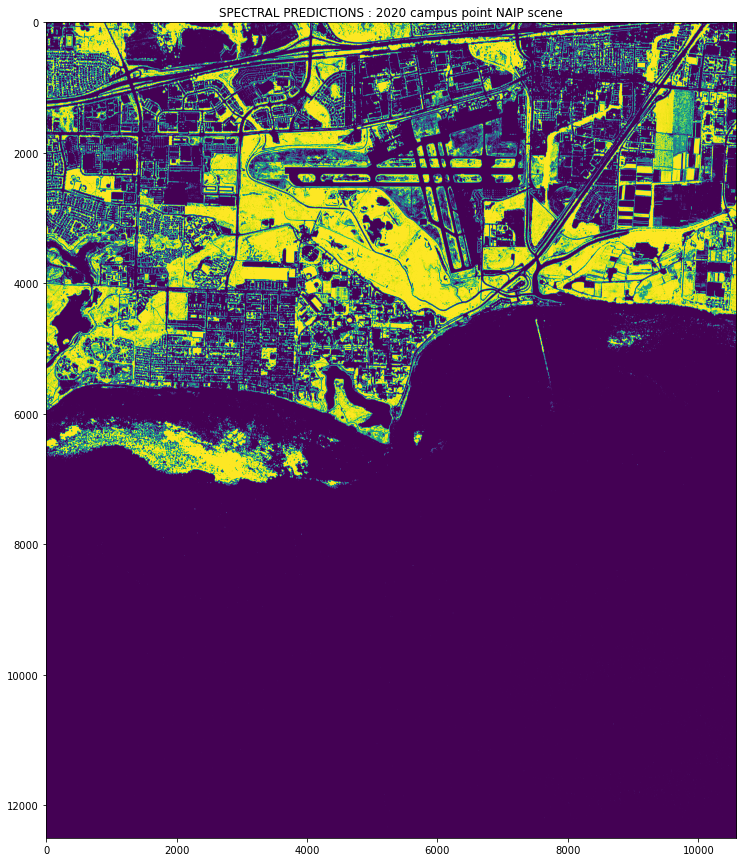

In [20]:
if plot_predictions == True:
    fig, ax = plt.subplots(figsize=(15, 15))
    plt.title(graph_title)
    ax.imshow(preds)
    plt.show()

## Save predictions if required

In [21]:
if save_raster == True:

    rast = ipf.get_raster_from_item(item)
    
    with rasterio.open(
        os.path.join(os.getcwd(),'temp',filename),  # file path
        'w',           # w = write
        driver = 'GTiff', # format
        height = preds.shape[0], 
        width = preds.shape[1],
        count = 1,  # number of raster bands in the dataset
        dtype = rasterio.uint8,
        crs = rast.crs,
        transform = rast.transform,
    ) as dst:
        dst.write(preds.astype(rasterio.uint8), 1)

In [22]:
print('total time:', time.time() - t_alpha )


total time: 468.7722918987274
